In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


num_classes = 2
num_features = model.fc.in_features
fc_layers = nn.Sequential(
    # nn.Linear
    nn.Linear(num_features, 2),
)
# model.fc = nn.Linear(num_features, 2);
model.fc = fc_layers

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


In [3]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/cifake/cifake.zip' -d folder

Streaming output truncated to the last 5000 lines.
  inflating: folder/train/REAL/4500 (10).jpg  
  inflating: folder/train/REAL/4500 (2).jpg  
  inflating: folder/train/REAL/4500 (3).jpg  
  inflating: folder/train/REAL/4500 (4).jpg  
  inflating: folder/train/REAL/4500 (5).jpg  
  inflating: folder/train/REAL/4500 (6).jpg  
  inflating: folder/train/REAL/4500 (7).jpg  
  inflating: folder/train/REAL/4500 (8).jpg  
  inflating: folder/train/REAL/4500 (9).jpg  
  inflating: folder/train/REAL/4500.jpg  
  inflating: folder/train/REAL/4501 (10).jpg  
  inflating: folder/train/REAL/4501 (2).jpg  
  inflating: folder/train/REAL/4501 (3).jpg  
  inflating: folder/train/REAL/4501 (4).jpg  
  inflating: folder/train/REAL/4501 (5).jpg  
  inflating: folder/train/REAL/4501 (6).jpg  
  inflating: folder/train/REAL/4501 (7).jpg  
  inflating: folder/train/REAL/4501 (8).jpg  
  inflating: folder/train/REAL/4501 (9).jpg  
  inflating: folder/train/REAL/4501.jpg  
  inflating: folder/train/REAL/4502

In [6]:
from sklearn.model_selection import train_test_split
import random

In [7]:
from torch.utils.data import Dataset, DataLoader
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image


In [9]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split


transform = transforms.Compose([
    transforms.Resize((33, 33)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset_path = '/content/folder'

class_names = ['FAKE', 'REAL']

full_dataset = ImageFolder(root=f"{dataset_path}/train", transform=transform)
full_dataset.class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=transform)
test_dataset.class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

batch_size = 16
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [10]:
torch.cuda.empty_cache()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00008, momentum=0.9)

train_losses = []
train_accs = []
val_losses = []
val_accs = []
test_losses = []
test_accs = []


num_epochs = 20


for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_data_loader)
    train_accuracy = correct / total

    # Evaluation on validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_data_loader)
    val_accuracy = correct / total

    # Evaluation on test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_data_loader)
    test_accuracy = correct / total


    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)
    #loss and accuracy after each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.4f} - "
          f"Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.4f}")


Epoch 1/20 - Train Loss: 0.5006 - Train Acc: 0.7571 - Val Loss: 0.4537 - Val Acc: 0.7896 - Test Loss: 0.4483 - Test Acc: 0.7933
Epoch 2/20 - Train Loss: 0.4542 - Train Acc: 0.7874 - Val Loss: 0.4244 - Val Acc: 0.8075 - Test Loss: 0.4213 - Test Acc: 0.8103
Epoch 3/20 - Train Loss: 0.4414 - Train Acc: 0.7946 - Val Loss: 0.4155 - Val Acc: 0.8134 - Test Loss: 0.4119 - Test Acc: 0.8137
Epoch 4/20 - Train Loss: 0.4348 - Train Acc: 0.7977 - Val Loss: 0.4120 - Val Acc: 0.8133 - Test Loss: 0.4064 - Test Acc: 0.8212
Epoch 5/20 - Train Loss: 0.4299 - Train Acc: 0.8012 - Val Loss: 0.4078 - Val Acc: 0.8162 - Test Loss: 0.4037 - Test Acc: 0.8183
Epoch 6/20 - Train Loss: 0.4252 - Train Acc: 0.8044 - Val Loss: 0.4038 - Val Acc: 0.8183 - Test Loss: 0.4013 - Test Acc: 0.8195
Epoch 7/20 - Train Loss: 0.4236 - Train Acc: 0.8059 - Val Loss: 0.4095 - Val Acc: 0.8167 - Test Loss: 0.4031 - Test Acc: 0.8173
Epoch 8/20 - Train Loss: 0.4228 - Train Acc: 0.8061 - Val Loss: 0.3977 - Val Acc: 0.8228 - Test Loss: 0.

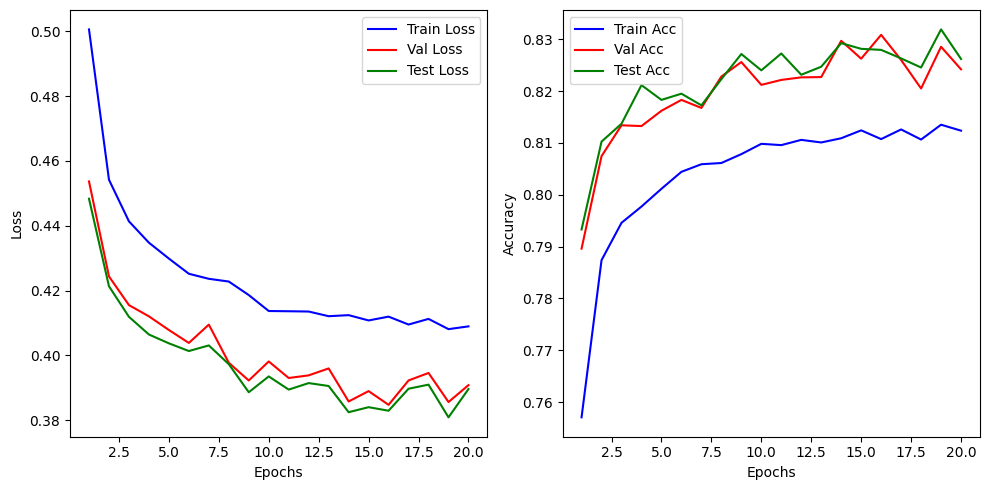

In [12]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Val Loss')
plt.plot(epochs, test_losses, 'g-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'b-', label='Train Acc')
plt.plot(epochs, val_accs, 'r-', label='Val Acc')
plt.plot(epochs, test_accs, 'g-', label='Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from PIL import Image

In [19]:
def predict_image(model, image_path, class_names):
    transform = transforms.Compose([
        transforms.Resize((33, 33)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    predicted_label = class_names[predicted.item()]

    print(f"Predicted: {predicted_label}")

# Example usage
image_path = "/content/folder/train/REAL/0007.jpg"
predict_image(model, image_path, class_names)

Predicted: REAL


In [20]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO

def predict_image(model, image_url, class_names, device):
    transform = transforms.Compose([
        transforms.Resize((54, 54)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))

    image = transform(image).unsqueeze(0)
    image = image.to(device)
    model = model.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    predicted_label = class_names[predicted.item()]

    # Display the predicted label
    print(f"Predicted: {predicted_label}")

# Example usage
# real photo from net
image_url = "https://qph.cf2.quoracdn.net/main-qimg-459d3ed325fa2c03b64158f4bd797539-pjlq"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predict_image(model, image_url, class_names, device)


Predicted: FAKE
